In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("dark", {'grid.linestyle': '--'})
# date

In [2]:
df = pd.read_csv("data/pazdra.csv",encoding="utf-8")
df = df.dropna()
date = pd.to_datetime(df["実装日"])
HP = df.HP.apply(lambda x: x.replace(',','')).astype(np.int)

## 普通にプロットしてみる

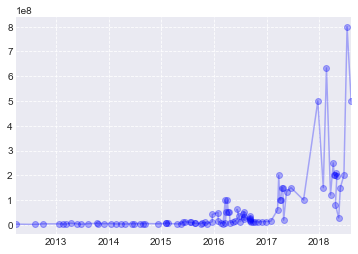

In [3]:
plt.plot(date,HP,"-o",color="blue",alpha=0.3)
plt.grid()
plt.xlim(date.values[0],date.values[-1])
plt.savefig("figures/7-1_normalplot.pdf")

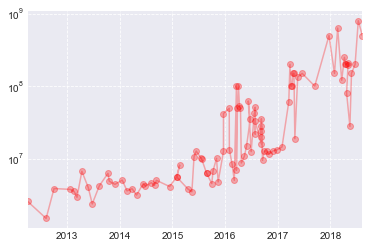

In [4]:
plt.plot(date,HP,"-o",color="red",alpha=0.3)
plt.yscale("log")
plt.grid()
plt.xlim(date.values[0],date.values[-1])
plt.savefig("figures/7-3_logplot.pdf")

## 最小二乗法で解く
$f(x) = ax+b$
aとbを探す

In [5]:
# 日付差分をとる
timedeltas = []
for i,(d,hp) in enumerate(zip(date,HP)):
    if i == 0:
        d_init = d
        timedeltas.append(0)
    else:
        delta = d-d_init        
        timedeltas.append(delta.days)
deltas = np.array(timedeltas)
hps = np.array(HP)

127298.81697650357 -109252207.6760954


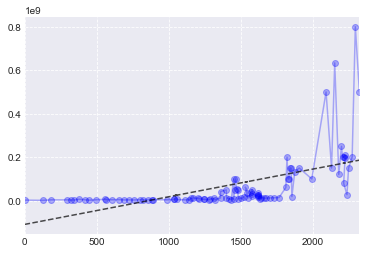

In [6]:
# overflowするので、補正
X = 100000000
hp_1 = hps/X
delta_1 = deltas/X
n = len(deltas)
# 最小二乗法
a = (n*np.dot(delta_1,hp_1)-(delta_1.sum()*hp_1.sum()))/(n*np.dot(delta_1,delta_1)-(delta_1.sum())**2)
b = (np.dot(delta_1,delta_1)*hp_1.sum()-np.dot(delta_1, hp_1)*delta_1.sum())/((n*np.dot(delta_1,delta_1)-(delta_1.sum())**2))*X
print(a,b)
ys = []
for d in deltas:
    ys.append(a*d+b)
plt.plot(deltas, hps,"-o", color="blue",alpha=0.3)
plt.plot(deltas, ys, "--",color="black",alpha=0.7)
plt.grid()
plt.xlim(deltas[0],deltas[-1])
plt.savefig("figures/7-2_normallsm.pdf")

## logを使って予測をする
- 最小二乗法+信頼区間95%内での予測。2018年8月10日までのデータを元に、365日後のHPはどのくらいになるか



- [t分布](https://algorithm.joho.info/programming/python-scipy-interval-estimation-t-mu/)
- [信頼区間](https://qiita.com/ksksk/items/75ba95337ccdb32e7cb1)
- 残差分散 : 重回帰分析においてデータ数をN,用いる説明変数の個数をpで表す。実測値と回帰による推定値との差の平方和をN-p-1で割ったのが残差分散である。


0.00226x+13.66


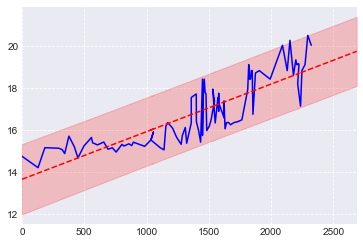

In [7]:
from scipy import stats
X = 100000000
hp_logs = np.log(hps)
hp_logs_1 = hp_logs/X
delta_1 = deltas/X
n = len(deltas)

ys = []
y_plus = []
y_minus = []

# 最小二乗法
a = (n*np.dot(delta_1,hp_logs_1)-(delta_1.sum()*hp_logs_1.sum()))/(n*np.dot(delta_1,delta_1)-(delta_1.sum())**2)
b = (np.dot(delta_1,delta_1)*hp_logs_1.sum()-np.dot(delta_1, hp_logs_1)*delta_1.sum())/((n*np.dot(delta_1,delta_1)-(delta_1.sum())**2))*X
print("{:.5f}x+{:.2f}".format(a,b))
for d in deltas:
    ys.append(a*d+b)
ys = np.array(ys)

# 信頼区間の算出
v_ye = np.dot(hp_logs-ys,hp_logs-ys)/n
v_xe = np.dot(deltas-deltas.mean(),deltas-deltas.mean())
alpha=0.95
for y,d in zip(ys,deltas):
#     SE = np.sqrt((1+1/n+(d-deltas.mean())**2/v_xe)*v_ye)
    SE = np.sqrt((1+1/n+(d-deltas.mean())**2/v_xe)*v_ye)
    t = stats.t.ppf(1-(1-alpha)/2, n-1)
    y_plus.append(y+t*SE)
    y_minus.append(y-t*SE)

# プラス1年分の予測
day = 365
delta_plus_1year = [d for d in deltas]
delta_plus_1year.append(deltas[-1]+day) #+1年
y = a*delta_plus_1year[-1]+b
y_p = y + t*SE
y_m = y - t*SE
ys = np.hstack((ys,y))
y_plus.append(y_p)
y_minus.append(y_m)
    
plt.fill_between(delta_plus_1year,y_plus,y_minus,alpha=0.2,color="red")
plt.plot(deltas, hp_logs,color="blue")
plt.plot(delta_plus_1year, ys, "--", color="red")
plt.grid()
plt.xlim(deltas[0],delta_plus_1year[-1])
plt.savefig("figures/7-4_loglsm.pdf")

## 一年後の敵の強さ
信頼区間95%なので、特殊な制限ダンジョンを除き、この範囲に収まるはず

- 最小 72,706,848
- 予測値 375,609,460
- 最大 1,940,428,856




In [8]:
print("MIN :", np.e**y_minus[-1])
print("PRED:",np.e**ys[-1])
print("MAX :", np.e**y_plus[-1])

MIN : 72706848.53636713
PRED: 375609460.6510859
MAX : 1940428856.024915


## ウェーバーフェヒナーの法則
刺激に気づくことができる最小の刺激差は、基準となる基礎刺激の強度に比例する
[参考 : wikipedia](https://ja.wikipedia.org/wiki/%E3%83%B4%E3%82%A7%E3%83%BC%E3%83%90%E3%83%BC%E2%80%90%E3%83%95%E3%82%A7%E3%83%92%E3%83%8A%E3%83%BC%E3%81%AE%E6%B3%95%E5%89%87)

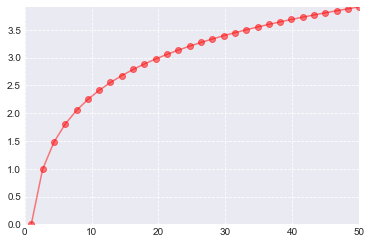

In [9]:
x = np.linspace(1,50,30)
y = np.log(x)
plt.plot(x,y,"r",marker="o",alpha=0.5)
plt.xlim(0,x[-1])
plt.ylim(y[0],y[-1])
plt.grid()
plt.savefig("figures/7-5_Weber-Fechner-law.pdf")